In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('./DP3 Historical Data.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\khaqt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - loss: 0.2051 - val_loss: 0.0019
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.0311 - val_loss: 0.0296
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0246 - val_loss: 0.0021
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0117 - val_loss: 5.7455e-04
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 0.0031 - val_loss: 2.3661e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.0022 - val_loss: 2.9603e-04
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.0024 - val_loss: 2.8144e-04
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0018 - val_loss: 2.7359e-04
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 0.0015 - val_loss: 2.3425e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0013 - val_loss: 2.3345e-04
Epoch 12/100

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [11]:
ytest_reshaped = ytest.reshape(-1, 1)

ytest_inverse = scaler.inverse_transform(ytest_reshaped)

In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest_inverse)**2))
test_mape = np.mean(np.abs((ytest_inverse - y_pred) / ytest_inverse)) * 100
test_msle = np.mean((np.log1p(ytest_inverse) - np.log1p(y_pred)) ** 2)

print('Testing RMSE:', test_rmse)
print('Test MAPE', test_mape)
print('Test MSLE', test_msle )

Testing RMSE: 1559.2361275269395
Test MAPE 1.5023443012372917
Test MSLE 0.0005123655868295948


In [14]:
# Predict next 30, 60, and 90 days
last_sequence_days = df1[-30:].reshape(1, 30, 1)
y_next_30_days = []
y_next_60_days = []
y_next_90_days = []

for i in range(90):
    next_day_pred = model.predict(last_sequence_days)
    if i < 30:
        y_next_30_days.append(next_day_pred[0][0])
    if i < 60:
        y_next_60_days.append(next_day_pred[0][0])
    y_next_90_days.append(next_day_pred[0][0])
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [15]:
# Inverse transform the predictions
y_next_30_days = scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)).flatten()
y_next_60_days = scaler.inverse_transform(np.array(y_next_60_days).reshape(-1, 1)).flatten()
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1)).flatten()

In [16]:
y_next_30_days

array([73915.41 , 73706.26 , 73534.79 , 73378.11 , 73229.68 , 73086.95 ,
       72948.66 , 72813.914, 72682.14 , 72552.86 , 72425.7  , 72300.38 ,
       72176.72 , 72054.484, 71933.555, 71813.82 , 71695.16 , 71577.516,
       71460.836, 71345.03 , 71230.07 , 71115.914, 71002.52 , 70889.87 ,
       70777.94 , 70666.695, 70556.14 , 70446.234, 70336.96 , 70228.33 ],
      dtype=float32)

In [17]:
# Print lengths
print("Length of y_next_30_days:", len(y_next_30_days))
print("Length of y_next_60_days:", len(y_next_60_days))
print("Length of y_next_90_days:", len(y_next_90_days))

Length of y_next_30_days: 30
Length of y_next_60_days: 60
Length of y_next_90_days: 90


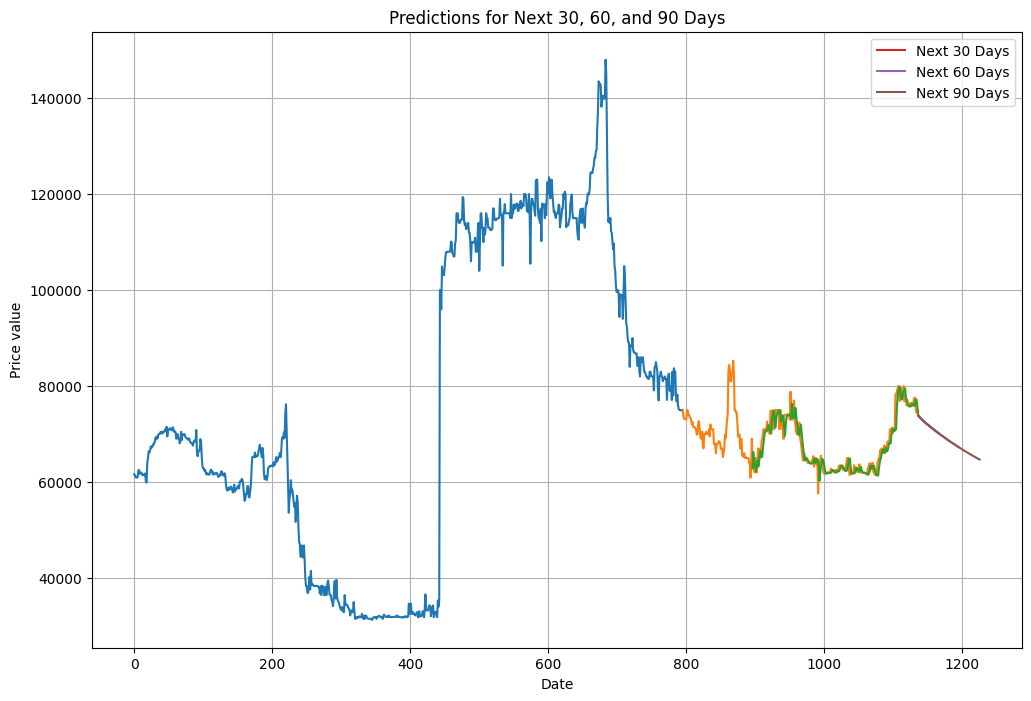

In [18]:
# Create date ranges for next 30, 60, and 90 days
next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
next_60_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
next_90_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)


# Plot the predictions
plt.figure(figsize=(12, 8))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
plt.plot(next_30_days_index, y_next_30_days, label='Next 30 Days')
plt.plot(next_60_days_index, y_next_60_days, label='Next 60 Days')
plt.plot(next_90_days_index, y_next_90_days, label='Next 90 Days')
plt.legend()
plt.grid()
plt.title("Predictions for Next 30, 60, and 90 Days")
plt.xlabel("Date")
plt.ylabel("Price value")
plt.savefig('next_days_predictions.png')
plt.show()